In [3]:
# import libraries
import json
import math
import os
from glob import glob
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import  img_to_array
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

In [4]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [5]:
import timeit

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [11]:
input_dir = "/content/drive/MyDrive/chest_xray/"
train_dir = input_dir +"/train/"
test_dir = input_dir +"/test/"
val_dir = input_dir +"/val/"

In [12]:
print(os.listdir(train_dir))
print(os.listdir(test_dir ))

['.DS_Store', 'NORMAL', 'PNEUMONIA']
['.DS_Store', 'PNEUMONIA', 'NORMAL']


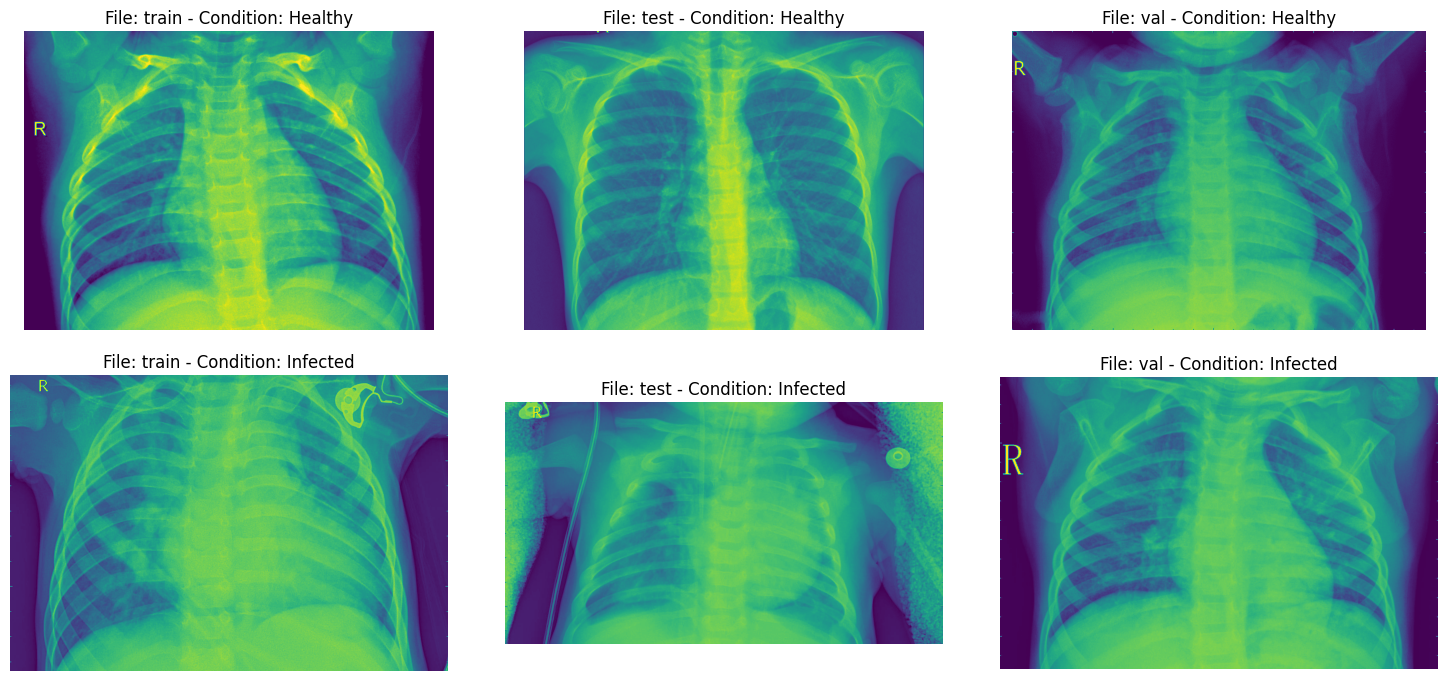

In [13]:
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout()
for i, _set in enumerate(['train','test','val']):
    set_path = input_dir+_set
    ax[i].axis('off')
    ax[i].imshow(plt.imread(set_path+"/NORMAL/"+os.listdir(set_path+"/NORMAL/")[0]))
    ax[i].set_title('File: {} - Condition: Healthy'.format(_set))
    ax[i+3].axis('off')
    ax[i+3].imshow(plt.imread(set_path+"/PNEUMONIA/"+os.listdir(set_path+"/PNEUMONIA/")[0]))
    ax[i+3].set_title('File: {} - Condition: Infected'.format(_set))

In [14]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                       zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

    test_val_datagen = ImageDataGenerator(rescale=1./255)

    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary')

    test_gen = test_val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_dims, img_dims),
    batch_size=batch_size,
    class_mode='binary')

    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(test_dir + cond)):
            img = plt.imread(test_dir+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels

In [15]:
img_dims = 150
batch_size = 20
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5268 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# validation_generator = test_datagen.flow_from_directory(
#         val_dir,
#         target_size=(150, 150),
#         batch_size=20,
#         class_mode='binary')

Found 5268 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


In [17]:
from keras.optimizers import Adam, RMSprop, Adamax

In [22]:
# Create Nasnet Model with Keras library

#adamax = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax", **kwargs)

# Create Nasnet Model with Keras library
import tensorflow

nasn =  tensorflow.keras.applications.NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(Dense(1000, activation="mish"))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation="sigmoid"))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adamax(lr=lr),
        metrics=['acc']
    )
    return model

model = build_model(nasn ,lr = 1e-4)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 5, 5, 1056)        4269716   
                                                                 
 batch_normalization_4 (Bat  (None, 5, 5, 1056)        4224      
 chNormalization)                                                
                                                                 
 global_average_pooling2d_4  (None, 1056)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1000)              1057000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [23]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)

# Fit Model
history2 = model.fit_generator(
    train_generator,
    steps_per_epoch=250,
    epochs=30,
    validation_data=test_generator,
    validation_steps=10,
    callbacks=[early_stopping_monitor]
)

<ipython-input-23-e47847532f06>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model.fit_generator(


Epoch 1/30
250/250 [==============================] - 2537s 10s/step - loss: 0.2020 - acc: 0.9218 - val_loss: 0.3431 - val_acc: 0.8400
Epoch 2/30
250/250 [==============================] - 247s 986ms/step - loss: 0.1197 - acc: 0.9537 - val_loss: 0.3041 - val_acc: 0.8500
Epoch 3/30
250/250 [==============================] - 118s 473ms/step - loss: 0.0986 - acc: 0.9665 - val_loss: 0.5225 - val_acc: 0.8400
Epoch 4/30
250/250 [==============================] - 117s 467ms/step - loss: 0.0916 - acc: 0.9699 - val_loss: 0.4717 - val_acc: 0.7950
Epoch 5/30
250/250 [==============================] - 118s 471ms/step - loss: 0.0834 - acc: 0.9701 - val_loss: 0.1740 - val_acc: 0.9600
Epoch 6/30
250/250 [==============================] - 113s 450ms/step - loss: 0.0775 - acc: 0.9723 - val_loss: 0.3363 - val_acc: 0.8900
Epoch 7/30
250/250 [==============================] - 116s 463ms/step - loss: 0.0596 - acc: 0.9781 - val_loss: 0.2086 - val_acc: 0.8950
Epoch 8/30
250/250 [=============================

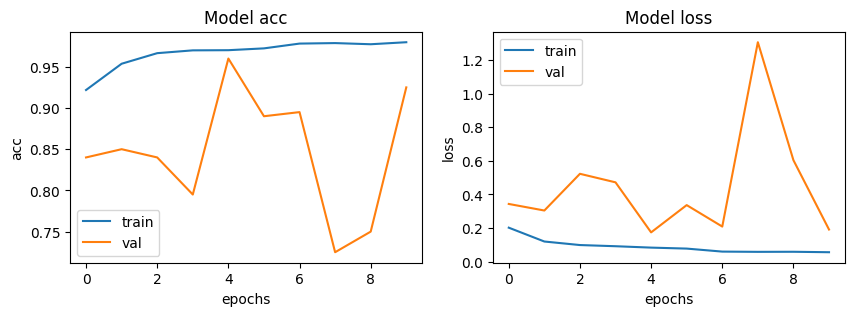

In [24]:
# Visualize Loss and Accuracy Rates
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

20/20 [==============================] - 8s 68ms/step
CONFUSION MATRIX


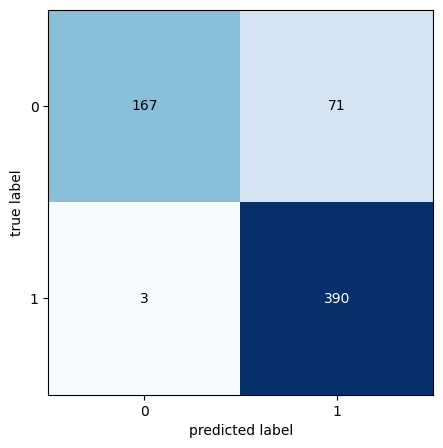


TEST METRICS ----------------------
Accuracy: 88.27258320126784%
Precision: 84.59869848156181%
Recall: 99.23664122137404%
F1-score: 91.33489461358313

TRAIN METRIC ----------------------
Train acc: 97.98


In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX')
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()
# print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history2.history['acc'][-1])*100, 2)))